In [37]:
"""
Implementation of trend-following strategy with absolute price oscillator while dynamically adjusting for volatility
"""

'\nImplementation of trend-following strategy with absolute price oscillator while dynamically adjusting for volatility\n'

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import math as math
from pandas_datareader import data

In [39]:
# we load the dataset 
# we use the same dataset for comparison
try:
    data_amzn = pd.read_pickle('amzn_data.pkl')
except:
    data_amzn = data.DataReader("AMZN",'yahoo','2015-01-01','2020-01-01')
    data_amzn.to_pickle('amzn_data.pkl')
data_amzn

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,15.737500,15.348000,15.629000,15.426000,55664000,15.426000
2015-01-05,15.419000,15.042500,15.350500,15.109500,55484000,15.109500
2015-01-06,15.150000,14.619000,15.112000,14.764500,70380000,14.764500
2015-01-07,15.064000,14.766500,14.875000,14.921000,52806000,14.921000
2015-01-08,15.157000,14.805500,15.016000,15.023000,61768000,15.023000
...,...,...,...,...,...,...
2019-12-24,89.778503,89.378998,89.690498,89.460503,17626000,89.460503
2019-12-26,93.523003,89.974998,90.050499,93.438499,120108000,93.438499
2019-12-27,95.070000,93.300499,94.146004,93.489998,123732000,93.489998


<AxesSubplot:xlabel='Date'>

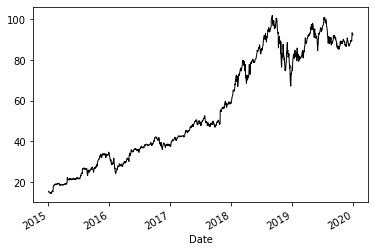

In [40]:
# before the preparation, we just observe the dataset first
data_amzn['Close'].plot(color = 'k',lw = 1)

1.5388011500701388

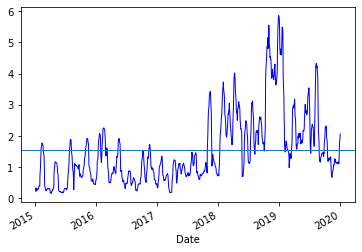

In [41]:
# then we check the total standard deviation
data_amzn['Close'].rolling(window = 20, min_periods = 1).std().plot(color = 'b',lw = 1)
total_mean = np.mean(data_amzn['Close'].rolling(window = 20, min_periods = 1).std())
plt.axhline(total_mean,lw = 1)
total_mean

# for convenience, even the mean_std = 1.5388011500701388, we will use 1.54
# 1.54 will be the standard we use to assess the volatility

In [42]:
# for the preparation, it is the same as the strategy without adjustment
# define the window_size for fast_ema and slow_ema
# for fast_ema, it is 10 days
fast = 10
k_fast = 2 / (fast+1)
ema_fast = 0
ema_fast_values = []

slow = 40 # 40 days for slow_ema
k_slow = 2 / (slow+1)
ema_slow = 0
ema_slow_values = []
apo_values = [] # we save it for buying / selling signals

In [43]:
# we save some variables for storing orders, positions, and profit & loss
orders = [] 
# -1: sell order
# 1: buy order
# 0: neutral

positions = []
# -1: short
# 1: long
# 0: netural

# open value - closed value
# sum of open pnl and closed pnl (lock-in profits - realized)
pnls = []

# we record the last buy/sell price to prevent overtrading
# we don't want to buy/sell just around the last buy/sell trade to ensure profits
last_buy_price = 0
last_sell_price = 0

# current position
position = 0

# summation quantity since last no position
buy_sum_qty = 0
sell_sum_qty = 0

buy_sum_price_qty = 0
sell_sum_price_qty = 0

# record open and closed pnls
open_pnls = 0
closed_pnls = 0

In [44]:
# we set up threshold for enter positions and the minimum price change since the last trade
apo_buy_entry = 5
apo_sell_entry = -5
min_price_movement = 5 # we use it prevent overtrading
num_shares = 10 # number of shares we will buy/sell at each trade
min_profit_to_close = 5*num_shares # if the profits > 5, regardless of apo, we exit the position

In [45]:
# now, we slighly modify the way we calculate ema
# we use std /  * k_fast / k_slow as the real factor
# we need a simple moving average for updating the standard deviation
# and we define the periods to be 20 days
sma_periods = 20
price_history = []

In [50]:
close = data_amzn['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > sma_periods:
        # we delete the first element to update the std
        del(price_history[0])
    
    # we calculate the variance
    sma = stats.mean(price_history)
    variance = 0
    for temp_price in price_history:
        variance += (temp_price - sma)**2
    
    std = (variance / len(price_history)) ** (0.5)
    # here, we define the std_factor as:
    # std_factor = std / 1.10
    std_factor = std / 1.538
    # if std_factor = 0, for our later calculation, we just set it to 1
    if std_factor == 0:
        std_factor = 1
    
    # we check whether the data is the first observation
    if ema_fast == 0:
        ema_fast = close_price
        ema_slow = close_price
    else:
        # we use our std_factor here
        ema_fast = k_fast*std_factor*close_price + (1-k_fast*std_factor)*ema_fast
        ema_slow = k_slow*std_factor*close_price + (1-k_slow*std_factor)*ema_slow
    
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    
    # calculate apo
    apo = ema_fast - ema_slow
    apo_values.append(apo)
    
    # we just need to slightly revise the apo part   
    # *** I gonna come back later for whether the conditions should be
    # apo < apo_sell_entry * std_factor
    # or:
    # apo < apo_sell_entry / std_factor
    
    # from my opinion, it should be apo < apo_sell_entry * std_factor
    # because we enter the position for low volatility
    # exit the trade for high volatility
    if (apo < apo_sell_entry * std_factor and abs(close_price - last_sell_price) > min_price_movement * std_factor) \
    or (position > 0 and (apo <= 0 or open_pnls > min_profit_to_close / std_factor)): # we exit for high volatility
        
        # why we multipy std_factor for the first condition: because now we are considering whether to enter a position
        # smaller std_factor ---> smaller volatility, meaning that we are likely to enter the position
        
        # why do we divide std_factor for the second condition:
        # we tend to leave with larger volatility
        orders.append(-1)
        last_sell_price = close_price
        position -= num_shares
        sell_sum_qty += num_shares
        sell_sum_price_qty += num_shares*close_price
        print("Sell ",num_shares, "@",close_price)
        print("Position:",position)
    # we apply the same logic to buy order
    elif (apo > apo_buy_entry * std_factor and abs(close_price - last_buy_price) > min_price_movement * std_factor) \
    or (position < 0 and (apo <= 0 or open_pnls > min_profit_to_close / std_factor)):
        orders.append(1)
        last_buy_price = close_price
        position += num_shares
        buy_sum_qty += num_shares
        buy_sum_price_qty += num_shares*close_price
        print("Buy ",num_shares, "@",close_price)
        print("Position:",position)
    else: # flat position
        orders.append(0)
    positions.append(position)
    
    # for open_pnls, it is the same as the original strategy
    open_pnls = 0
    
    if position > 0:
        # we need to minus some closed pnls if position > 0 but sell_qty > 0
        # because that means our position is long, but we have done some selling against this trade
        # we will minus the closed pnls
        if sell_sum_qty > 0:
            # we use an average price difference for calculation
            open_pnls += sell_sum_qty*(sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # then we set the remaining to open pnls with respect to market price
        
        # why do we use (sell_sum_qty - buy_sum_qty): we want the unrealized buy_sum_qty
        # why do we use (close_price - buy_sum_price / buy_sum_qty):
        # because we want to calculate the profits if we close at current price
        # we want to sell at close_price because we have long position
        open_pnls += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    
    # we now look at the case for short position
    elif position < 0:
        # that means we have some realized buy orders
        if buy_sum_qty > 0:
            open_pnls += buy_sum_qty * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        
        # we want to calculate the unrealized buy open pnls
        
        # why do we use (sell_sum_price_qty / sell_sum_qty-open_price):
        # now out position is short, and we want to buy back at the current open_price 
        open_pnls += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty-close_price)
    else:
        # the position is 0, we just update close_pnls
        # open_pnls is 0. we can directly use sell_sum_price_qty - buy_sum_price_qty
        closed_pnls += (sell_sum_price_qty - buy_sum_price_qty)
        
        # and we reset the sum_price_qty 
        buy_sum_price_qty = 0
        sell_sum_price_qty = 0
        
        buy_sum_qty = 0
        sell_sum_qty = 0
        
        last_buy_price = 0
        last_sell_price = 0
    print("OpenPnL: ", open_pnls, " ClosedPnL: ", closed_pnls)
    print("Totl PnL:",closed_pnls+open_pnls)
    pnls.append(closed_pnls+open_pnls)
    

OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPnL:  0  ClosedPnL:  429.7599792480469
Totl PnL: 429.7599792480469
OpenPn

OpenPnL:  0.0  ClosedPnL:  400.05496978759766
Totl PnL: 400.05496978759766
Buy  10 @ 25.52750015258789
Position: 0
OpenPnL:  0  ClosedPnL:  393.04996490478516
Totl PnL: 393.04996490478516
Sell  10 @ 25.236000061035156
Position: -10
OpenPnL:  0.0  ClosedPnL:  393.04996490478516
Totl PnL: 393.04996490478516
Buy  10 @ 24.950000762939453
Position: 0
OpenPnL:  0  ClosedPnL:  395.9099578857422
Totl PnL: 395.9099578857422
Sell  10 @ 25.87700080871582
Position: -10
OpenPnL:  0.0  ClosedPnL:  395.9099578857422
Totl PnL: 395.9099578857422
Buy  10 @ 25.844499588012695
Position: 0
OpenPnL:  0  ClosedPnL:  396.23497009277344
Totl PnL: 396.23497009277344
Sell  10 @ 26.11199951171875
Position: -10
OpenPnL:  0.0  ClosedPnL:  396.23497009277344
Totl PnL: 396.23497009277344
Buy  10 @ 26.472000122070312
Position: 0
OpenPnL:  0  ClosedPnL:  392.6349639892578
Totl PnL: 392.6349639892578
Sell  10 @ 26.069000244140625
Position: -10
OpenPnL:  0.0  ClosedPnL:  392.6349639892578
Totl PnL: 392.6349639892578
Buy 

OpenPnL:  -5.639991760253906  ClosedPnL:  292.04002380371094
Totl PnL: 286.40003204345703
OpenPnL:  -4.015007019042969  ClosedPnL:  292.04002380371094
Totl PnL: 288.02501678466797
OpenPnL:  -9.575004577636719  ClosedPnL:  292.04002380371094
Totl PnL: 282.4650192260742
OpenPnL:  -5.7649993896484375  ClosedPnL:  292.04002380371094
Totl PnL: 286.2750244140625
OpenPnL:  -4.8600006103515625  ClosedPnL:  292.04002380371094
Totl PnL: 287.1800231933594
OpenPnL:  -7.4700164794921875  ClosedPnL:  292.04002380371094
Totl PnL: 284.57000732421875
OpenPnL:  -1.7300033569335938  ClosedPnL:  292.04002380371094
Totl PnL: 290.31002044677734
Buy  10 @ 34.948001861572266
Position: 20
OpenPnL:  -13.289985656738281  ClosedPnL:  292.04002380371094
Totl PnL: 278.75003814697266
OpenPnL:  -20.89000701904297  ClosedPnL:  292.04002380371094
Totl PnL: 271.15001678466797
OpenPnL:  -4.300041198730469  ClosedPnL:  292.04002380371094
Totl PnL: 287.73998260498047
OpenPnL:  3.3499526977539062  ClosedPnL:  292.0400238037

OpenPnL:  0  ClosedPnL:  552.60498046875
Totl PnL: 552.60498046875
OpenPnL:  0  ClosedPnL:  552.60498046875
Totl PnL: 552.60498046875
OpenPnL:  0  ClosedPnL:  552.60498046875
Totl PnL: 552.60498046875
Buy  10 @ 48.57699966430664
Position: 10
OpenPnL:  0.0  ClosedPnL:  552.60498046875
Totl PnL: 552.60498046875
OpenPnL:  4.405021667480469  ClosedPnL:  552.60498046875
Totl PnL: 557.0100021362305
OpenPnL:  10.919990539550781  ClosedPnL:  552.60498046875
Totl PnL: 563.5249710083008
OpenPnL:  12.120018005371094  ClosedPnL:  552.60498046875
Totl PnL: 564.7249984741211
OpenPnL:  12.579994201660156  ClosedPnL:  552.60498046875
Totl PnL: 565.1849746704102
OpenPnL:  11.539993286132812  ClosedPnL:  552.60498046875
Totl PnL: 564.1449737548828
OpenPnL:  12.205009460449219  ClosedPnL:  552.60498046875
Totl PnL: 564.8099899291992
OpenPnL:  17.594985961914062  ClosedPnL:  552.60498046875
Totl PnL: 570.1999664306641
OpenPnL:  19.90001678466797  ClosedPnL:  552.60498046875
Totl PnL: 572.504997253418
Open

OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPn

OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPnL:  0  ClosedPnL:  543.4799957275391
Totl PnL: 543.4799957275391
OpenPn

In [51]:
# now we want to visualize the result
data_amzn['Fast_EMA'] = pd.Series(ema_fast_values,index = data_amzn.index)
data_amzn['Slow_EMA'] = pd.Series(ema_slow_values,index = data_amzn.index)
data_amzn['APO'] = pd.Series(apo_values,index = data_amzn.index)
data_amzn['Orders'] = pd.Series(orders,index = data_amzn.index)
data_amzn['Position'] = pd.Series(positions,index = data_amzn.index)
data_amzn['PnL'] = pd.Series(pnls,index = data_amzn.index)
data_amzn['APO']

ValueError: Length of values (2516) does not match length of index (1258)

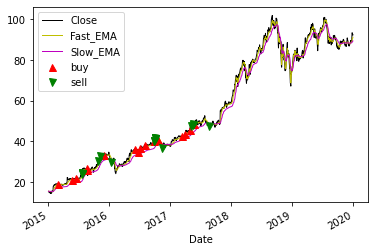

In [52]:
data_amzn['Close'].plot(color = 'k',lw = 1)
data_amzn['Fast_EMA'].plot(color = 'y',lw = 1)
data_amzn['Slow_EMA'].plot(color = 'm',lw = 1)
# we show our order
plt.plot(data_amzn.loc[data_amzn.Orders == 1].index, data_amzn.Close[data_amzn.Orders == 1],lw = 0,label = 'buy', markersize = 7,marker = '^',color = 'r')
plt.plot(data_amzn.loc[data_amzn.Orders == -1].index, data_amzn.Close[data_amzn.Orders == -1],lw = 0,label = 'sell', markersize = 7,marker = 'v',color = 'g')
plt.legend()

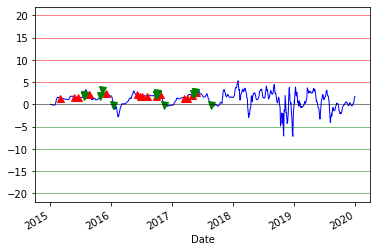

In [53]:
# we also display the apo values and buy/sell orders
data_amzn['APO'].plot(color ='b',lw = 1)
plt.plot(data_amzn.loc[data_amzn.Orders == 1].index, data_amzn.APO[data_amzn.Orders == 1],color = 'r',marker = '^',markersize = 7,lw = 0, label = 'buy')
plt.plot(data_amzn.loc[data_amzn.Orders == -1].index, data_amzn.APO[data_amzn.Orders == -1],color = 'g',marker = 'v',markersize = 7,lw = 0, label = 'sell')

# we draw some horizontal lines to see where to buy and where to sell more clearly
plt.axhline(y = 0, lw = 0.5, color = 'k')

for i in range(apo_buy_entry, apo_buy_entry*5,apo_buy_entry):
    plt.axhline(y = i,lw = 0.5, color = 'r')

    
for i in range(apo_sell_entry, apo_sell_entry*5,apo_sell_entry):
    plt.axhline(y = i,lw = 0.5, color = 'g')

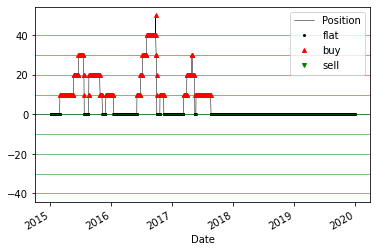

In [54]:
data_amzn['Position'].plot(color = 'k',lw = 0.5)
plt.plot(data_amzn[data_amzn.Position == 0].index, data_amzn.Position[data_amzn.Position == 0],marker = '.',markersize = 4,color = 'k',lw = 0, label = 'flat')
plt.plot(data_amzn[data_amzn.Position > 0].index, data_amzn.Position[data_amzn.Position >0],marker = '^',markersize = 4,color = 'r',lw = 0, label = 'buy')
plt.plot(data_amzn[data_amzn.Position < 0].index, data_amzn.Position[data_amzn.Position <0],marker = 'v',markersize = 4,color = 'g',lw = 0, label = 'sell')

plt.axhline(y = 0, lw = 0.5, color = 'k')

for i in range(num_shares, num_shares*5,num_shares):
    plt.axhline(y = i,lw = 0.5, color = 'r')

for i in range(0, -num_shares*5,-num_shares):
    plt.axhline(y = i,lw = 0.5, color = 'g')
    
plt.legend()

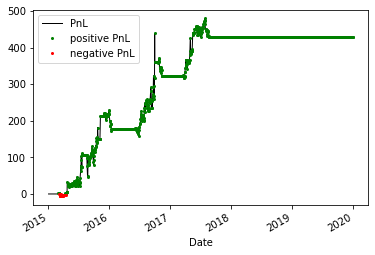

In [55]:
data_amzn['PnL'].plot(color = 'k',lw = 1)
# green represents positive pnl
plt.plot(data_amzn[data_amzn.PnL > 0].index, data_amzn.PnL[data_amzn.PnL> 0],marker = '.',color = 'g',lw = 0,markersize = 4,label = 'positive PnL')
plt.plot(data_amzn[data_amzn.PnL < 0].index, data_amzn.PnL[data_amzn.PnL< 0],marker = '.',color = 'r',lw = 0,markersize = 4,label = 'negative PnL')
plt.legend()

In [ ]:
# compare it with the mean_reversion strategy,
# we find that we are making money

# compared it with the original trend following strategy,
# it also makes more money

# this conclusion contradicts the one in the textbook ---- I will test more stocks to see which conclusion is true